# Dataset

The datased used is https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Imports

In [24]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import HistGradientBoostingClassifier

# Dataset Exploration

In [12]:
fake_df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
fake_df['label'] = 0
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [10]:
true_df = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')
true_df['label'] = 1
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [13]:
df = true_df.copy(deep=True)
df = df.append(fake_df, ignore_index=True)
df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


It seems that `subject` column does not give us any significant value here. Fake and real news have completely different subject names. One can exploit this in order to classify fake news without even using ML. Although, we will try to solve this problem using a ML classifier.

In [14]:
print(f"Dataset subject unique values: {df['subject'].unique()}")

Dataset subject unique values: ['politicsNews' 'worldnews' 'News' 'politics' 'Government News'
 'left-news' 'US_News' 'Middle-east']


No empty cells are detected.

In [15]:
print(df.columns[df.isnull().any()])

Index([], dtype='object')


The dataset is pretty balanced. The number of fake news is almost equal to the real ones.

<AxesSubplot:xlabel='label', ylabel='count'>

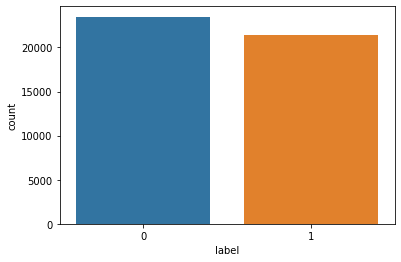

In [16]:
sns.countplot(x=df['label'], data=df)

### Word Cloud

In [ ]:
fake_text = ' '.join(fake_df['title']) + ' '.join(fake_df['text'])
true_text = ' '.join(true_df['title']) + ' '.join(true_df['text'])

wordcloud_fake = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='black', 
                           width=12000, height=10000).generate(fake_text)
wordcloud_true = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='black', 
                           width=12000, height=10000).generate(true_text)

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title('Fake News')
plt.show()

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title('Real News')
plt.show()

New word cloud

In [28]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

AttributeError: 'DataFrame' object has no attribute 'category'

<Figure size 1440x1440 with 0 Axes>

# Data Pre-processing

In this step we should clean up our data from:
- redundant columns: `subject`, `date`
- stopwords
- punctuation
- urls


In [9]:
# Concatenate titles & text
X = df['title'] + ' ' + df['text']
y = df['label']

punctuation_regex = re.compile(r'[^\w\s]+')
urls_regex = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+'
                        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+['
                        r'a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-'
                        r'zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')

# Apply data cleaning
X = X.apply(lambda x: urls_regex.sub('', str(x)))
X = X.apply(lambda x: ' '.join([item for item in x.split() if item not in ENGLISH_STOP_WORDS]))
X = X.apply(lambda x: punctuation_regex.sub('', str(x)))

# Split data to 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

# Random Forests + TF-IDF

In [16]:
# Set up the model pipeline
# Note: the parameters are extracted through offline gridsearch param tuning
# We are using TF-IDF vectorizer in order to transform the text.
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(lowercase=True, max_features=10000, ngram_range=(1,2))),
        ('clf', HistGradientBoostingClassifier(max_features='sqrt', n_estimators=1000, n_jobs=-1))
    ]
)

# Creating a StratifiedKFold object with 5 splits
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

scores = cross_validate(pipeline, X_train, y_train,
                        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                        cv=5,
                        n_jobs=-1,
                        return_train_score=False)

print('Cross validation scores', scores)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

TypeError: __init__() got an unexpected keyword argument 'max_features'